<a href="https://colab.research.google.com/github/dAn-solution/competition/blob/main/Prob_kiva_020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kiva／クラウドファンディングの資金調達額予測
- CNN を実施
- [回帰：燃費を予測する](https://www.tensorflow.org/tutorials/keras/regression?hl=ja) 参照

### Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'

Mounted at /content/drive
/content/drive/My Drive


### ライブラリのインストール、インポート

In [ ]:
# カレントディレクトリを変更
import os
os.chdir('/content/drive/My Drive/Probdata/kiva/')
print(os.getcwd())

/content/drive/My Drive/Probdata/kiva


In [ ]:
class Config():
    root_path = './'
    input_path = os.path.join(root_path, 'input')
    output_path = os.path.join(root_path, 'output')
    result_path = os.path.join(root_path, 'result')
    bert_model_name = 'bert-base-uncased'
    seed = 42
    constant = 25
    debug = False

In [ ]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers

### データの読み込み

In [ ]:
train_df = pd.read_csv(f'{Config.input_path}/train.csv')
test_df = pd.read_csv(f'{Config.input_path}/test.csv')
sample_df = pd.read_csv(f'{Config.input_path}/sample_submission.csv')

train_tags_pca = np.load(f'{Config.result_path}/train_tags_pca.npy')
test_tags_pca = np.load(f'{Config.result_path}/test_tags_pca.npy')
train_bert_pca = np.load(f'{Config.result_path}/train_bert_pca.npy')
test_bert_pca = np.load(f'{Config.result_path}/test_bert_pca.npy')
train_bert_018_pca = np.load(f'{Config.result_path}/train_bert_018_pca.npy')
test_bert_018_pca = np.load(f'{Config.result_path}/test_bert_018_pca.npy')

train_X_pca = np.load(f'{Config.result_path}/train_X_pca.npy')
test_X_pca = np.load(f'{Config.result_path}/test_X_pca.npy')

## CNNの実行

In [ ]:
target_column = "LOAN_AMOUNT"
y = train_df[target_column]

In [ ]:
train_pca = np.concatenate([train_X_pca, train_tags_pca, train_bert_pca, train_bert_018_pca], axis=1)
test_pca = np.concatenate([test_X_pca, test_tags_pca, test_bert_pca, test_bert_018_pca], axis=1)

# X = pd.concat([X, pd.DataFrame(train_pca)], axis=1)
# test_X = pd.concat([test_X, pd.DataFrame(test_pca)], axis=1)
X = pd.DataFrame(train_pca)
test_X = pd.DataFrame(test_pca)
print(X.shape)
print(test_X.shape)

(91333, 18)
(91822, 18)


In [ ]:
# # trainデータを訓練用とテスト用に分割
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = Config.seed)

- modelの構築

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(300, activation='relu', input_dim=X.shape[1]),
    keras.layers.BatchNormalization(),
    layers.Dense(200, activation='relu'),
    keras.layers.BatchNormalization(),
    layers.Dense(100, activation='relu'),
    keras.layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)

  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae'])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               5700      
                                                                 
 batch_normalization (BatchN  (None, 300)              1200      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 batch_normalization_1 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [ ]:
example_batch = X[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.02176261],
       [ 0.8528855 ],
       [ 0.44989282],
       [ 0.14449972],
       [ 0.34390253],
       [ 0.00107759],
       [-0.64207184],
       [-0.92742807],
       [-0.7829318 ],
       [ 0.02160871]], dtype=float32)

- modelの訓練

In [ ]:
EPOCHS = 500
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


In [ ]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示

history = model.fit(
  X, y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [ ]:
# mae
print("mae = ", mean_absolute_error(model.predict(X), y))

mae =  287.3206908468982


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
495,310.284180,310.284180,328.192688,328.192688,495
496,310.069550,310.069550,332.430023,332.430023,496
497,312.170471,312.170471,324.413696,324.413696,497
498,313.064026,313.064026,328.376984,328.376984,498
499,311.117615,311.117615,327.997620,327.997620,499


In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()
  plt.show()


# plot_history(history)

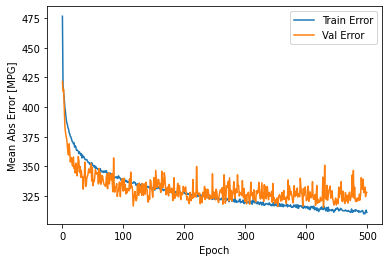

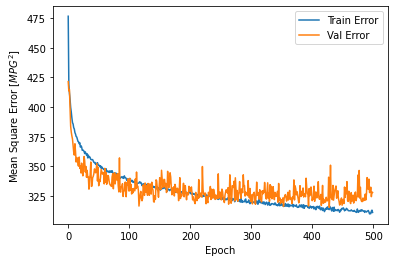

In [ ]:
plot_history(history)


..........................................

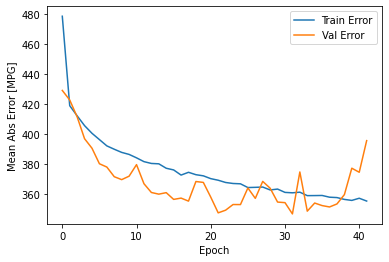

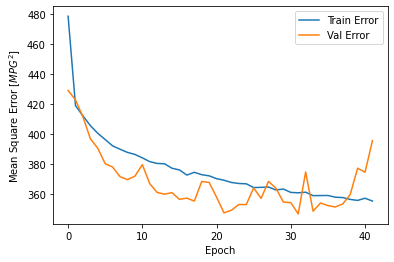

In [ ]:
# model = build_model()

# # patience は改善が見られるかを監視するエポック数を表すパラメーター
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# history = model.fit(X, y, epochs=EPOCHS,
#                     validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

# plot_history(history)

In [ ]:
# loss, mae = model.evaluate(X_test, y_test, verbose=2)

# print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

− modelを使った予測

In [ ]:
train_predictions = model.predict(X).flatten()
test_predictions = model.predict(test_X).flatten()

In [ ]:
print(train_predictions.shape)
print(test_predictions.shape)

(91333,)
(91822,)


In [ ]:
print(mean_absolute_error(train_predictions, y))

287.3206908468982


In [ ]:
# メタモデルへの引き渡し
train_020_df = pd.DataFrame(train_predictions)
train_020_df.to_csv(os.path.join(Config.result_path, "train_020.csv"), index=False)

test_020_df = pd.DataFrame(test_predictions)
test_020_df.to_csv(os.path.join(Config.result_path, "test_020.csv"), index=False)

### 提出データの作成

In [ ]:
for i in range(len(test_predictions)):
    a, b = divmod(test_predictions[i], Config.constant)
    if b > (Config.constant/2):
        b = 1
    else:
        b = 0
    test_predictions[i] = (a + b) * Config.constant

In [ ]:
sample_df["LOAN_AMOUNT"] = test_predictions
print(sample_df)

       LOAN_ID  LOAN_AMOUNT
0      2041445        250.0
1      1944435        350.0
2      2083354        300.0
3      1993565        625.0
4      2064272        175.0
...        ...          ...
91817  1993862        200.0
91818  2015070        125.0
91819  1950349        375.0
91820  1921580       1450.0
91821  1976733        325.0

[91822 rows x 2 columns]


In [ ]:
# submitファイルのファイル名に利用する作成時刻の取得

now = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=1)))
date_time = "{0:%Y%m%d_%H%M}".format(now)

In [ ]:
# submitファイルの出力(Google Driveに出力）
# 形式：submit_yyyymmdd_hhmm.csv

sample_df.to_csv(os.path.join(Config.output_path, f"submit_{date_time}.csv"), index=False)
